# ASSIGNMENT 4

## Clustering,  Feature Seclection and Dimentionality Reduction

### Apurva Agrawal [axa177331]

### Imporitng Libraries

In [111]:
import csv
import numpy as np
import pandas as pd 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model

from sklearn.decomposition import FastICA, PCA
from sklearn import random_projection

from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score
from sklearn.metrics import zero_one_loss
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.feature_selection import SelectFromModel

import itertools

import collections

from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [144]:
## function for k means clustering plot

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

sns.set(style="whitegrid")

def plot_cluster(n_clusters, X):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=6)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = cm.get_cmap("Spectral")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [156]:
## for plotting expectation maximization results

from scipy import linalg
import matplotlib as mpl

def EM_win(X, splot, clf):
    # Plot the winner
    color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                                  'darkorange'])
    Y_ = clf.predict(X)
    for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                               color_iter)):
        v, w = linalg.eigh(cov)
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan2(w[0][1], w[0][0])
        angle = 180. * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(.5)
        splot.add_artist(ell)

    plt.xticks(())
    plt.yticks(())
    plt.title('Selected GMM: full model, 2 components')
    plt.subplots_adjust(hspace=.35, bottom=.02)
    plt.show()

### DATASET 1 : STUDENT PERFORMANCE

In [172]:
raw_data=pd.read_csv("student-mat.csv", sep=';')
raw_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [173]:
#numeric columns
raw_num = raw_data.select_dtypes(exclude=[object])
#categorical columns
raw_cat = raw_data.select_dtypes(include=[object])
#creating dummies for categorical columns
raw_enc = pd.get_dummies(raw_cat)
#joining to get raw_data with dummies
raw_dum = raw_num.join(raw_enc)
#dropping G1 and G2
data_g3=raw_dum.drop(['G1','G2'], axis=1)
data_g3.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,3,4,3,2,2,...,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,...,1,0,0,1,0,1,1,0,1,0


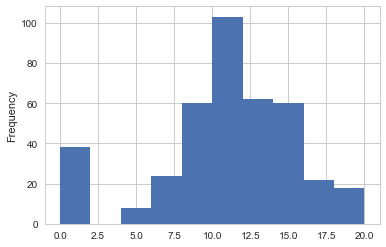

In [174]:
# plot G3 to see the distribution to decide the value for distinguishing class
data_g3['G3'].plot.hist()

### Since clustering algorithms do not do well when data has outliers, we first remove outliers from our dataset

In [175]:
data_g3.shape

(395, 57)

In [176]:
# removing data with grade less than 2.5
data_g3 = data_g3[data_g3['G3'] > 2.5]
data_g3.shape

(357, 57)

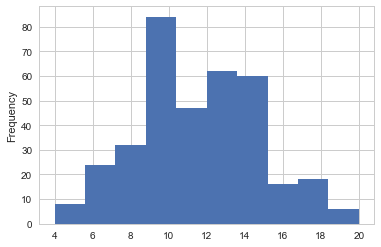

In [177]:
data_g3['G3'].plot.hist()

In [178]:
#feature scaling (not G3)
scaler = MinMaxScaler()
data_g3[['age','Medu','Fedu','traveltime','studytime','failures','famrel','freetime','goout','Dalc','Walc','health','absences']] =scaler.fit_transform(data_g3[['age','Medu','Fedu','traveltime','studytime','failures','famrel','freetime','goout','Dalc','Walc','health','absences']])
data_g3.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,0.428571,1.00,1.00,0.333333,0.333333,0.0,0.75,0.50,0.75,0.00,...,1,0,0,1,0,1,1,0,1,0
1,0.285714,0.25,0.25,0.000000,0.333333,0.0,1.00,0.50,0.50,0.00,...,1,0,1,0,0,1,0,1,1,0
2,0.000000,0.25,0.25,0.000000,0.333333,1.0,0.75,0.50,0.25,0.25,...,1,0,0,1,0,1,0,1,1,0
3,0.000000,1.00,0.50,0.000000,0.666667,0.0,0.50,0.25,0.25,0.00,...,0,1,0,1,0,1,0,1,0,1
4,0.142857,0.75,0.75,0.000000,0.333333,0.0,0.75,0.50,0.25,0.00,...,1,0,0,1,0,1,1,0,1,0


In [179]:
df_X = data_g3.drop(['G3'],axis=1)
df_X.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,0.428571,1.00,1.00,0.333333,0.333333,0.0,0.75,0.50,0.75,0.00,...,1,0,0,1,0,1,1,0,1,0
1,0.285714,0.25,0.25,0.000000,0.333333,0.0,1.00,0.50,0.50,0.00,...,1,0,1,0,0,1,0,1,1,0
2,0.000000,0.25,0.25,0.000000,0.333333,1.0,0.75,0.50,0.25,0.25,...,1,0,0,1,0,1,0,1,1,0
3,0.000000,1.00,0.50,0.000000,0.666667,0.0,0.50,0.25,0.25,0.00,...,0,1,0,1,0,1,0,1,0,1
4,0.142857,0.75,0.75,0.000000,0.333333,0.0,0.75,0.50,0.25,0.00,...,1,0,0,1,0,1,1,0,1,0


In [180]:
data_g3['G3'] = np.where(data_g3['G3']>= 11, 1, 0)
df_y = data_g3['G3']
df_y.head()

0    0
1    0
2    0
3    1
4    0
Name: G3, dtype: int32

In [181]:
X_train,X_test,y_train,y_test = train_test_split(df_X,df_y,test_size=0.3, random_state = 2)

In [182]:
# checking if the train and test datasets are balanced
print(collections.Counter(y_train))
print(collections.Counter(y_test))

Counter({1: 147, 0: 102})
Counter({1: 62, 0: 46})


## TASK 1

## K Means

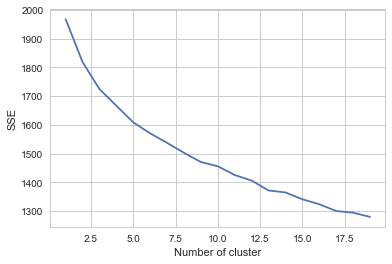

In [186]:
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=2).fit(X_train)
    # kmeans.fit(X_train)
    # data["clusters"] = kmeans.labels_
    # print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

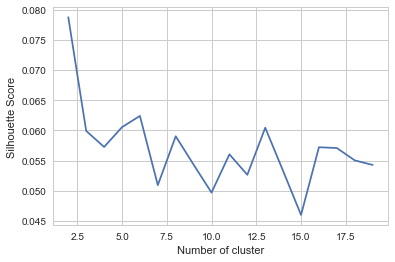

In [187]:
sil_coeff = {}
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=2).fit(X_train)
    label = kmeans.labels_
    sil_coeff[k] = silhouette_score(X_train, label, metric='euclidean')
    #print("For k={}, The SCoeff is {}".format(k, sil_coeff))
plt.figure()
plt.plot(list(sil_coeff.keys()), list(sil_coeff.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.show()

For n_clusters = 6 The average silhouette_score is : 0.05701426137047464


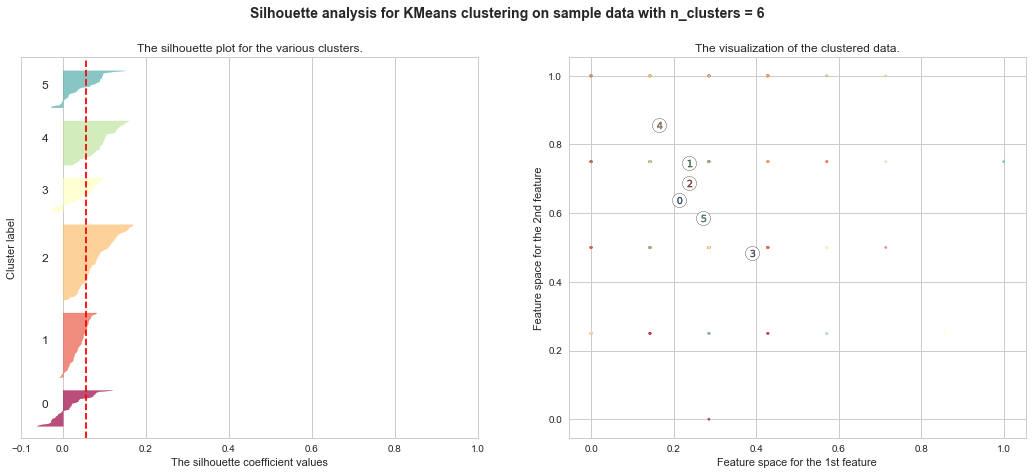

In [191]:
X = np.array(X_train)
plot_cluster(6, X)

In [192]:
# Traing k-means
kmeans = KMeans(n_clusters = 6, random_state=2)
kmeans.fit(X_train, y_train)

y_pred_kmeans_train = kmeans.predict(X_train)
y_pred_kmeans_test = kmeans.predict(X_test)

## Expectation Maximization (using Gaussian mixtures)

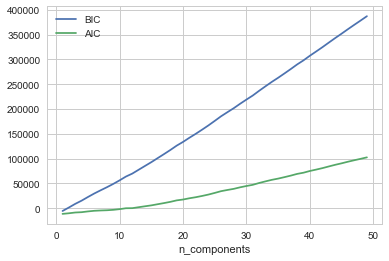

In [193]:
n_components = np.arange(1, 50)
models = [GMM(n, covariance_type='full', random_state=2).fit(X_train)
          for n in n_components]

plt.plot(n_components, [m.bic(X_train) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_train) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

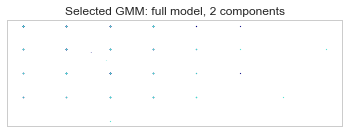

In [195]:
X = np.array(X_train)
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X)
splot = plt.subplot(2, 1, 2)
EM_win(X, splot, clf)

In [196]:
# Traing EM
gmm = GMM(n_components = 2, random_state=2)
gmm.fit(X_train, y_train)

y_pred_gmm_train = gmm.predict(X_train)
y_pred_gmm_test = gmm.predict(X_test)

### Observations:
1) For K-means, optimal number of clusters are 6  but the Silhouette Score is very low which means overlapping clusters

2) For EM, optimal number of clusters are 2.However this algorithm doesn't seem to be suitable here

## Task 2

## Dimensionality Reduction

## Decision Tree

In [197]:
X = df_X
y = df_y
clf =  DecisionTreeClassifier(max_depth=5, random_state = 2)  # 5 based on previous assignment 2 observation
clf = clf.fit(X, y)
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
print(X_new.shape)
print(X.shape)

(357, 12)
(357, 56)


#### We got 12 imporatnat features using tree depth of 5

In [198]:
df_X1 = X_new                                                      #Filter independent variables

#Train and test splits
X_train_dt,X_test_dt,y_train_dt,y_test_dt = train_test_split(df_X1,df_y,test_size=0.3, random_state = 2)

y_train_dt = np.array(y_train).flatten()                                    #For linear regression
y_test_dt = np.array(y_test).flatten()                                      #For linear regression

## Principal Component Analysis

[Text(0,0.5,'Cummulative Explained Variance'), Text(0.5,0,'No. of Components')]

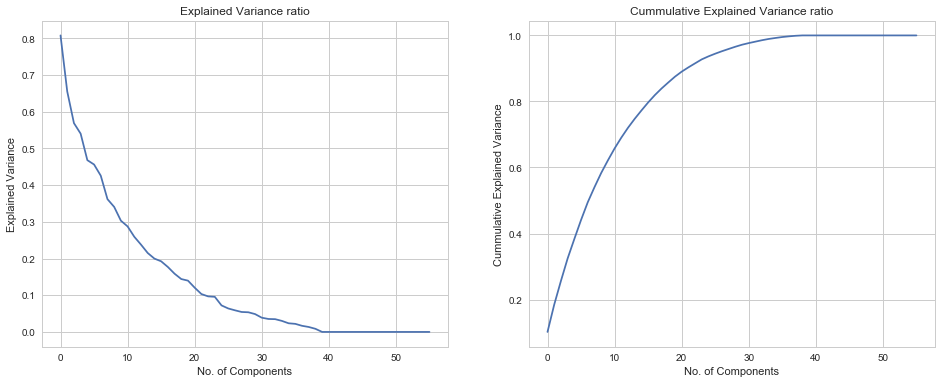

In [199]:
pca = PCA(random_state = 2)
pca.fit(X_train)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Explained Variance plot
ax[0].plot(pca.explained_variance_)
ax[0].set_title('Explained Variance ratio')
ax[0].set(xlabel='No. of Components', ylabel='Explained Variance')

# Cummulative variance explained
ax[1].plot(np.cumsum(pca.explained_variance_ratio_))
ax[1].set_title('Cummulative Explained Variance ratio')
ax[1].set(xlabel='No. of Components', ylabel='Cummulative Explained Variance')

#### As observed, 20 components seem to explain the variance of the dataset

In [200]:
pca = PCA(n_components = 20, random_state = 2)
X_train_pca = pca.fit_transform(X_train, y_train)
X_test_pca = pca.fit_transform(X_test, y_test)

### Independent Component Analysis

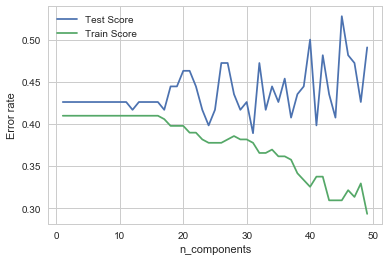

In [201]:
n_components = range(1,50,1)
error_test = []
error_train = []

for i in range(0, len(n_components)):
    ica = FastICA(n_components = n_components[i], whiten = True, random_state=2)
    X_train_ica = ica.fit_transform(X_train, y_train)
    X_test_ica = ica.fit_transform(X_test, y_test)

    # comparing with logistic regression to determine the error rate
    
    logreg = linear_model.LogisticRegression()
    logreg.fit(X_train_ica, y_train)
    
    error_test.append(zero_one_loss(y_test, logreg.predict(X_test_ica)))
    error_train.append(zero_one_loss(y_train, logreg.predict(X_train_ica)))


sns.set(style="whitegrid")


plt.plot(n_components, error_test)
plt.plot(n_components, error_train)
plt.xlabel('n_components')
plt.ylabel('Error rate')

plt.legend(['Test Score', 'Train Score'])

#### 25 components seem to be a good choice for number of indepedent components

In [202]:
ica = FastICA(n_components = 25, whiten = True, random_state = 2)
X_train_ica = ica.fit_transform(X_train, y_train)
X_test_ica = ica.fit_transform(X_test, y_test)

### Randomized Projections

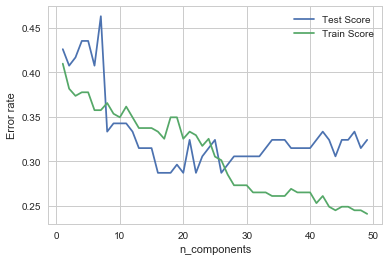

In [231]:
n_components = range(1,50,1)
error_test = []
error_train = []

for i in range(0, len(n_components)):
    ra = random_projection.GaussianRandomProjection(n_components = n_components[i], random_state=7)
    X_train_ra = ra.fit_transform(X_train)
    X_test_ra = ra.fit_transform(X_test, y_test)

    # comparing with logistic regression to determine the error rate
    
    logreg = linear_model.LogisticRegression()
    logreg.fit(X_train_ra, y_train)
    
    error_test.append(zero_one_loss(y_test, logreg.predict(X_test_ra)))
    error_train.append(zero_one_loss(y_train, logreg.predict(X_train_ra)))


sns.set(style="whitegrid")


plt.plot(n_components, error_test)
plt.plot(n_components, error_train)
plt.xlabel('n_components')
plt.ylabel('Error rate')

plt.legend(['Test Score', 'Train Score'])

#### 15 components seem to be a good choice for number of randomized components

In [232]:
ra = random_projection.GaussianRandomProjection(n_components = 18, random_state = 2)
ra.fit(X_train)
X_train_ra = ra.fit_transform(X_train)
X_test_ra = ra.fit_transform(X_test, y_test)

## Task 3

## Clustering post dimensionality reduction

### K means 

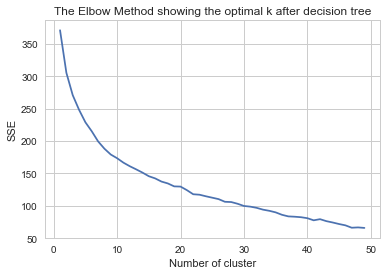

In [204]:
# Post decision tree

sse = {}
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, random_state=2).fit(X_train_dt)
    # kmeans.fit(X_train)
    # data["clusters"] = kmeans.labels_
    # print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title('The Elbow Method showing the optimal k after decision tree')
plt.show()

For n_clusters = 10 The average silhouette_score is : 0.19384094678814132


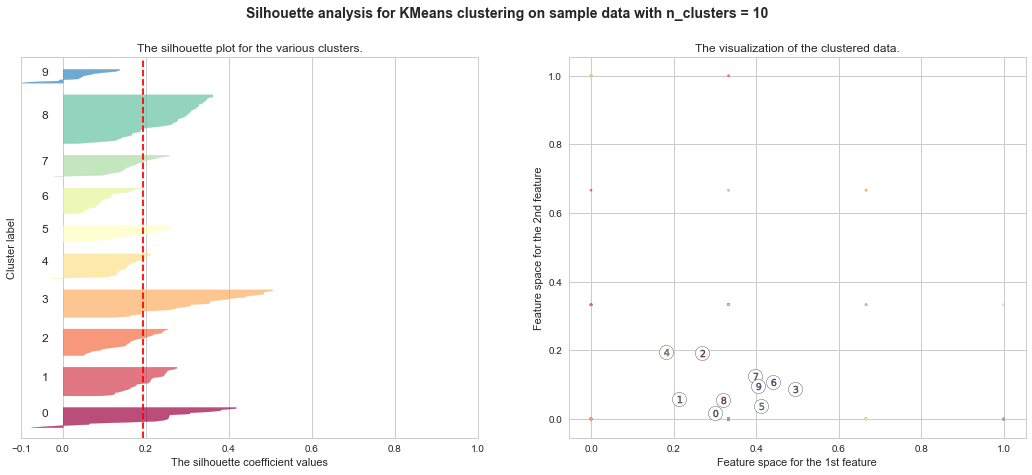

In [205]:
#X = np.array(X_train_dt)
plot_cluster(10, X_train_dt)

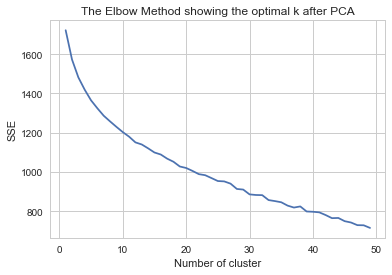

In [206]:
# Post PCA

sse = {}
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, random_state=2).fit(X_train_pca)
    # kmeans.fit(X_train)
    # data["clusters"] = kmeans.labels_
    # print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title('The Elbow Method showing the optimal k after PCA')
plt.show()

For n_clusters = 10 The average silhouette_score is : 0.06559708607005295


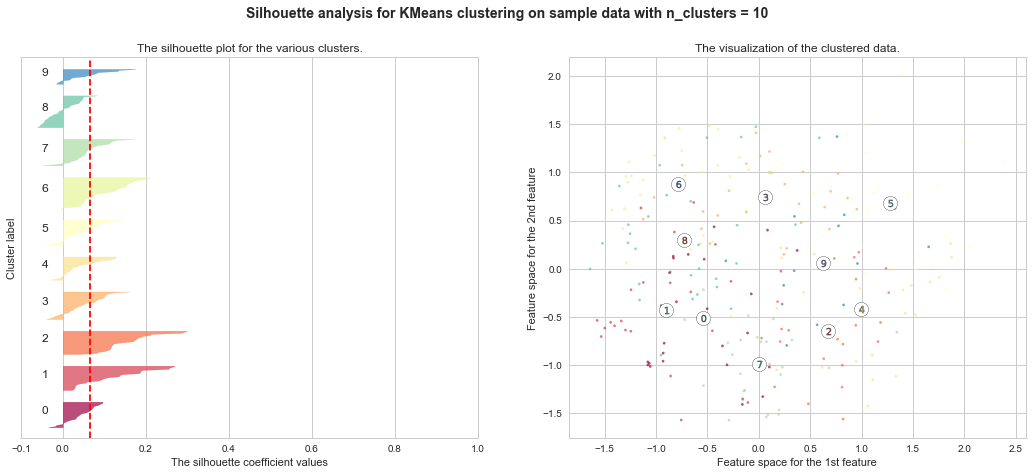

In [207]:
plot_cluster(10, X_train_pca)

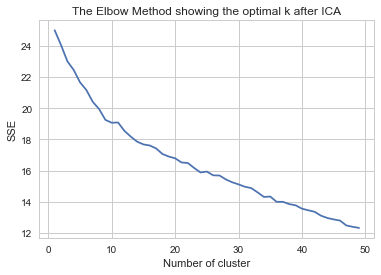

In [208]:
# Post ICA

sse = {}
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, random_state=2).fit(X_train_ica)
    # kmeans.fit(X_train)
    # data["clusters"] = kmeans.labels_
    # print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title('The Elbow Method showing the optimal k after ICA')
plt.show()

For n_clusters = 8 The average silhouette_score is : 0.050634486782031564


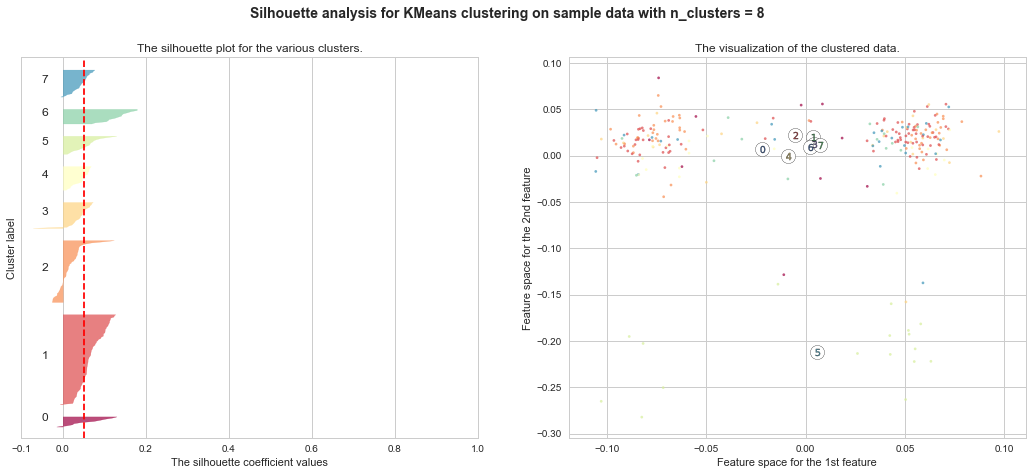

In [209]:
plot_cluster(8, X_train_ica)

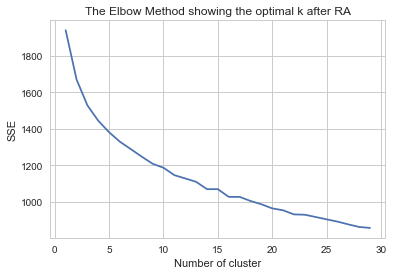

In [233]:
# Post RA

sse = {}
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, random_state=2).fit(X_train_ra)
    # kmeans.fit(X_train)
    # data["clusters"] = kmeans.labels_
    # print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title('The Elbow Method showing the optimal k after RA')
plt.show()

For n_clusters = 5 The average silhouette_score is : 0.08951092147655533


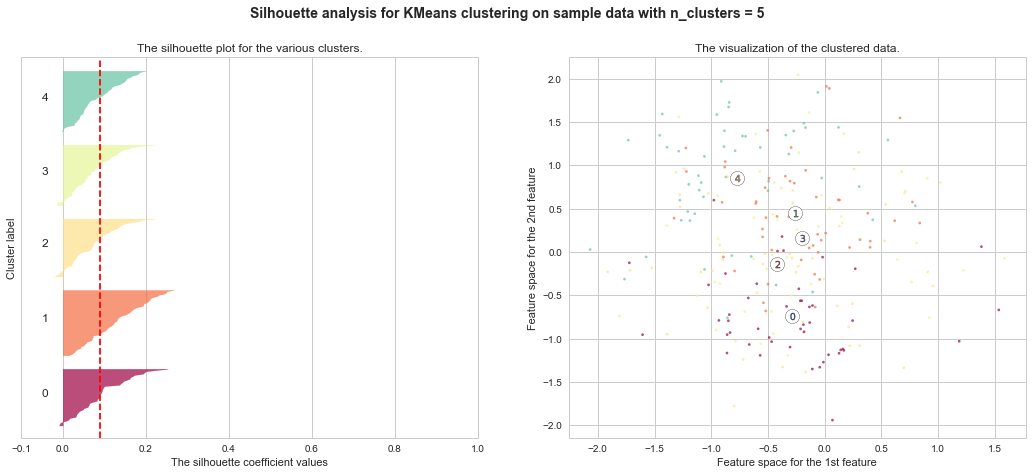

In [234]:
plot_cluster(5, X_train_ra)

### Expectation Maximization

Text(0.5,1,'The AIC/BIC plot for Expectation Maximization after decision tree')

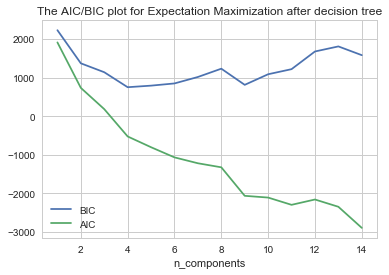

In [213]:
## Post decision tree

n_components = np.arange(1, 15)
models = [GMM(n, covariance_type='full', random_state=2).fit(X_train_dt)
          for n in n_components]

plt.plot(n_components, [m.bic(X_train_dt) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_train_dt) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');
plt.title('The AIC/BIC plot for Expectation Maximization after decision tree')

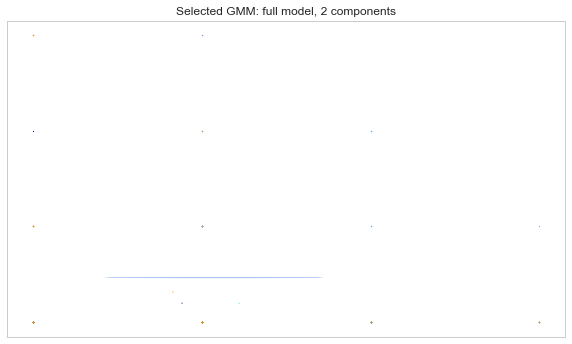

In [214]:
clf = mixture.GaussianMixture(n_components=4, covariance_type='full')
clf.fit(X_train_dt)
plt.figure(figsize = (10,12))
splot = plt.subplot(2, 1, 2)
EM_win(X_train_dt, splot, clf)

Text(0.5,1,'The AIC/BIC plot for Expectation Maximization after PCA')

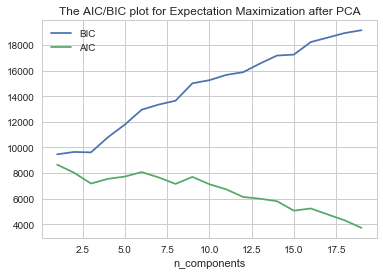

In [215]:
## Post PCA

n_components = np.arange(1, 20)
models = [GMM(n, covariance_type='full', random_state=2).fit(X_train_pca)
          for n in n_components]

plt.plot(n_components, [m.bic(X_train_pca) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_train_pca) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');
plt.title('The AIC/BIC plot for Expectation Maximization after PCA')

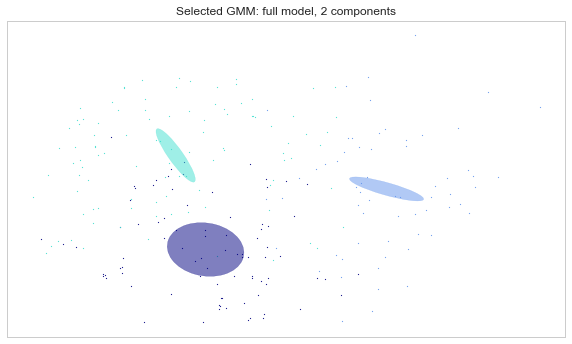

In [216]:
clf = mixture.GaussianMixture(n_components=3, covariance_type='full')
clf.fit(X_train_pca)
plt.figure(figsize = (10,12))
splot = plt.subplot(2, 1, 2)
EM_win(X_train_pca, splot, clf)

Text(0.5,1,'The AIC/BIC plot for Expectation Maximization after ICA')

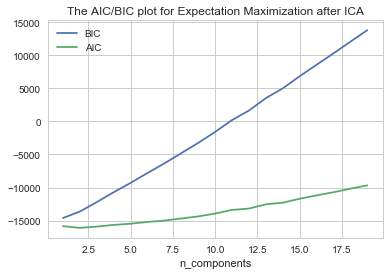

In [217]:
## Post ICA

n_components = np.arange(1, 20)
models = [GMM(n, covariance_type='full', random_state=2).fit(X_train_ica)
          for n in n_components]

plt.plot(n_components, [m.bic(X_train_ica) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_train_ica) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');
plt.title('The AIC/BIC plot for Expectation Maximization after ICA')

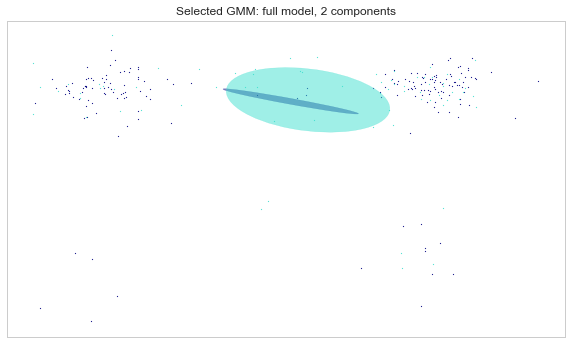

In [218]:
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X_train_ica)
plt.figure(figsize = (10,12))
splot = plt.subplot(2, 1, 2)
EM_win(X_train_ica, splot, clf)

Text(0.5,1,'The AIC/BIC plot for Expectation Maximization after RA')

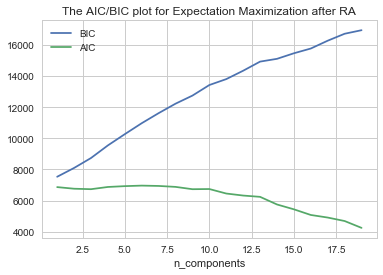

In [235]:
## Post RA

n_components = np.arange(1, 20)
models = [GMM(n, covariance_type='full', random_state=2).fit(X_train_ra)
          for n in n_components]

plt.plot(n_components, [m.bic(X_train_ra) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_train_ra) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');
plt.title('The AIC/BIC plot for Expectation Maximization after RA')

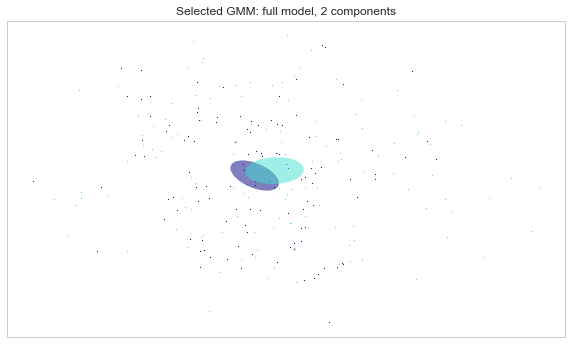

In [236]:
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X_train_ra)
plt.figure(figsize = (10,12))
splot = plt.subplot(2, 1, 2)
EM_win(X_train_ra, splot, clf)

## Task 4

## Neural Netwroks post Dimension reduction

#### Post Decision Tree

In [221]:
mlp = MLPClassifier(hidden_layer_sizes=(10,5), activation = 'tanh', tol=1e-4, random_state=2)
mlp.fit(X_train_dt, y_train_dt)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 5), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=2, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [222]:
y_pred = mlp.predict(X_test_dt)
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))

[[20 26]
 [11 51]]
             precision    recall  f1-score   support

          0       0.65      0.43      0.52        46
          1       0.66      0.82      0.73        62

avg / total       0.66      0.66      0.64       108



Confusion matrix, without normalization
[[20 26]
 [11 51]]


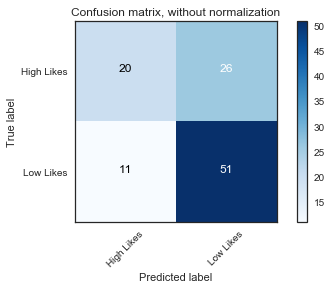

In [223]:
sns.set_style('white')

## Confusion Matrix

class_names = ['High Likes', 'Low Likes']


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

### Post PCA

In [224]:
mlp = MLPClassifier(hidden_layer_sizes=(10,5), activation = 'tanh', tol=1e-4, random_state=2)
mlp.fit(X_train_pca, y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 5), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=2, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [225]:
y_pred = mlp.predict(X_test_pca)
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))

[[10 36]
 [28 34]]
             precision    recall  f1-score   support

          0       0.26      0.22      0.24        46
          1       0.49      0.55      0.52        62

avg / total       0.39      0.41      0.40       108



Confusion matrix, without normalization
[[10 36]
 [28 34]]


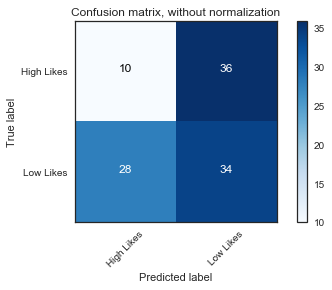

In [226]:
sns.set_style('white')

## Confusion Matrix

class_names = ['High Likes', 'Low Likes']


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

### Post ICA

In [227]:
mlp = MLPClassifier(hidden_layer_sizes=(10,5), activation = 'tanh', tol=1e-4, random_state=2)
mlp.fit(X_train_ica, y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 5), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=2, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [228]:
y_pred = mlp.predict(X_test_ica)
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))

[[16 30]
 [20 42]]
             precision    recall  f1-score   support

          0       0.44      0.35      0.39        46
          1       0.58      0.68      0.63        62

avg / total       0.52      0.54      0.53       108



Confusion matrix, without normalization
[[16 30]
 [20 42]]


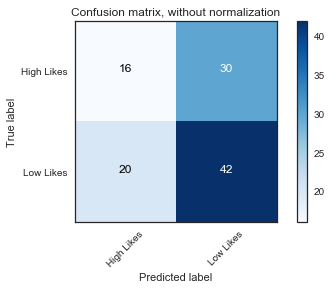

In [229]:
sns.set_style('white')

## Confusion Matrix

class_names = ['High Likes', 'Low Likes']


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

### Post RA

In [237]:
mlp = MLPClassifier(hidden_layer_sizes=(10,5), activation = 'tanh', tol=1e-4, random_state=2)
mlp.fit(X_train_ra, y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 5), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=2, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [238]:
y_pred = mlp.predict(X_test_ra)
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))

[[12 34]
 [ 5 57]]
             precision    recall  f1-score   support

          0       0.71      0.26      0.38        46
          1       0.63      0.92      0.75        62

avg / total       0.66      0.64      0.59       108



Confusion matrix, without normalization
[[12 34]
 [ 5 57]]


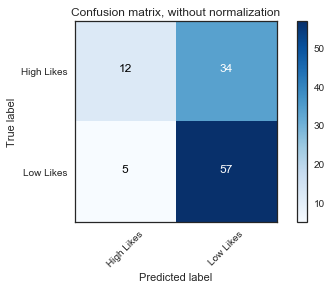

In [239]:
sns.set_style('white')

## Confusion Matrix

class_names = ['High Likes', 'Low Likes']


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

## Task 5

### Neural Networks with post clustering data

#### using k means features

In [240]:
features_kmeans_train = y_pred_kmeans_train.reshape(-1,1)
features_kmeans_test = y_pred_kmeans_test.reshape(-1,1)

In [241]:
mlp = MLPClassifier(hidden_layer_sizes=(10,5), activation = 'tanh', tol=1e-4, random_state=2)
mlp.fit(features_kmeans_train, y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 5), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=2, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [242]:
y_pred = mlp.predict(features_kmeans_test)
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))

[[ 0 46]
 [ 0 62]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        46
          1       0.57      1.00      0.73        62

avg / total       0.33      0.57      0.42       108



Confusion matrix, without normalization
[[ 0 46]
 [ 0 62]]


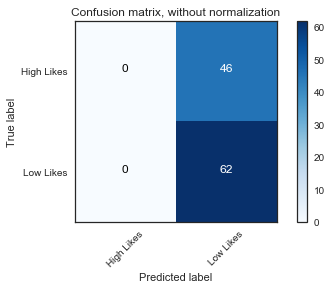

In [243]:
sns.set_style('white')

## Confusion Matrix

class_names = ['High Likes', 'Low Likes']


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

#### using expectation maximization features

In [244]:
features_gmm_train = y_pred_gmm_train.reshape(-1,1)
features_gmm_test = y_pred_gmm_test.reshape(-1,1)

In [245]:
mlp = MLPClassifier(hidden_layer_sizes=(10,5), activation = 'tanh', tol=1e-4, random_state=2)
mlp.fit(features_gmm_train, y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 5), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=2, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [246]:
y_pred = mlp.predict(features_gmm_test)
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))

[[ 0 46]
 [ 0 62]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        46
          1       0.57      1.00      0.73        62

avg / total       0.33      0.57      0.42       108



Confusion matrix, without normalization
[[ 0 46]
 [ 0 62]]


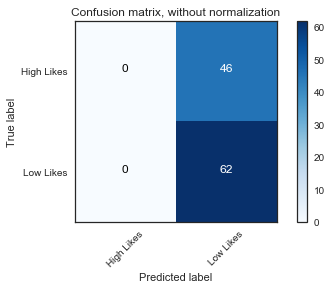

In [247]:
sns.set_style('white')

## Confusion Matrix

class_names = ['High Likes', 'Low Likes']


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

### DATASET 2: ONLINE NEWS POPULARITY

In [45]:
raw_data2 = pd.read_csv("OnlineNewsPopularity.csv")
raw_data2.columns = raw_data2.columns.str.strip()

raw_data2.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [46]:
data2 = raw_data2.drop('url', axis=1)
data2 = data2.drop('timedelta', axis=1)
data2.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


(1, 10000)

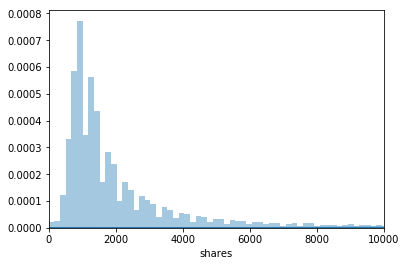

In [47]:
g = sns.distplot(data2['shares'], bins = 5000)
g.set_xlim(1, 10000)

### Since clustering algorithms do not do well when data has outliers, we first remove outliers from our dataset

In [48]:
data2.shape

(39644, 59)

In [49]:
# removing data with shares less than 250 or greater than 4000
data2 = data2[data2['shares'] < 4000]
data2 = data2[data2['shares'] > 250]

In [50]:
data2.shape   #data without outliers

(32764, 59)

In [51]:
data2.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


(1, 5000)

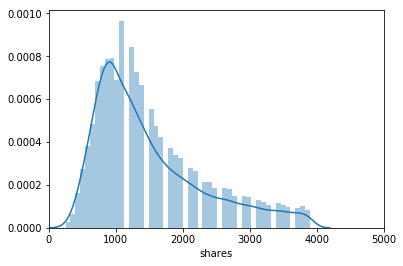

In [52]:
g1 = sns.distplot(data2['shares'])
g1.set_xlim(1, 5000)

In [53]:
# making shares categorical: >1500 as 1, otherwise 0
data2['shares'] = np.where(data2['shares'] >= 1500, 1, 0)
data2.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,0
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,0
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,0
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,0


In [56]:
data2.groupby('shares').count() #checking if the dataset is balanced

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
shares,,,,,,,,,,,,,,,,,,,,,
0,19862,19862,19862,19862,19862,19862,19862,19862,19862,19862,...,19862,19862,19862,19862,19862,19862,19862,19862,19862,19862
1,12902,12902,12902,12902,12902,12902,12902,12902,12902,12902,...,12902,12902,12902,12902,12902,12902,12902,12902,12902,12902


In [57]:
df_X = data2.drop(['shares'],axis=1)
df_X.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364


In [58]:
df_y = data2['shares']
df_y.head()

0    0
1    0
2    1
3    0
4    0
Name: shares, dtype: int32

In [59]:
scaler = MinMaxScaler()
scaler.fit(df_X)
df_X =np.array(scaler.transform(df_X))

In [60]:
#Train and test splits
X_train,X_test,y_train,y_test = train_test_split(df_X,df_y,test_size=0.3, random_state = 5)
y_train = np.array(y_train).flatten()                               
y_test = np.array(y_test).flatten()

In [62]:
# checking if the train and test datasets are balanced
print(collections.Counter(y_train))
print(collections.Counter(y_test))

Counter({0: 13848, 1: 9086})
Counter({0: 6014, 1: 3816})


## TASK 1

## K Means

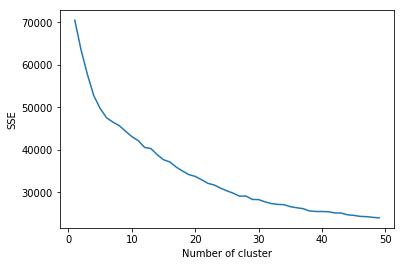

In [70]:
sse = {}
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, random_state=2).fit(X_train)
    # kmeans.fit(X_train)
    # data["clusters"] = kmeans.labels_
    # print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

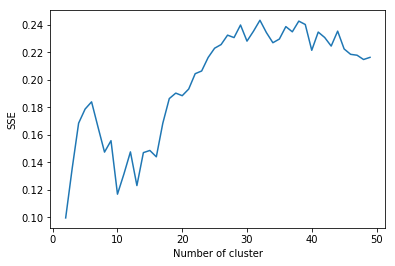

In [69]:
sil_coeff = {}
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, random_state=2).fit(X_train)
    label = kmeans.labels_
    sil_coeff[k] = silhouette_score(X_train, label, metric='euclidean')
    #print("For k={}, The SCoeff is {}".format(k, sil_coeff))
plt.figure()
plt.plot(list(sil_coeff.keys()), list(sil_coeff.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.show()

For n_clusters = 30 The average silhouette_score is : 0.2396710895810879


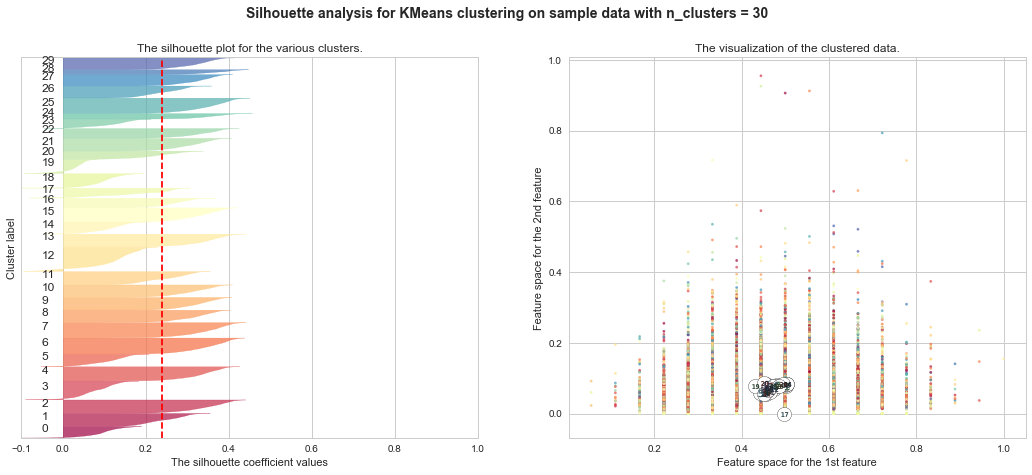

In [145]:
plot_cluster(30, X_train)

In [71]:
# Traing k-means
kmeans = KMeans(n_clusters = 30, random_state=2)
kmeans.fit(X_train, y_train)

y_pred_kmeans_train = kmeans.predict(X_train)
y_pred_kmeans_test = kmeans.predict(X_test)

## Expectation Maximization (using Gaussian mixtures)

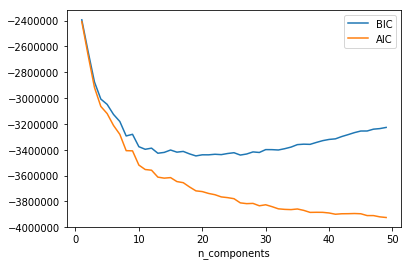

In [73]:
n_components = np.arange(1, 50)
models = [GMM(n, covariance_type='full', random_state=2).fit(X_train)
          for n in n_components]

plt.plot(n_components, [m.bic(X_train) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_train) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

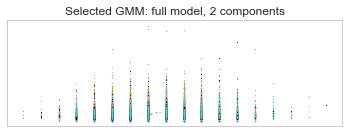

In [157]:
clf = mixture.GaussianMixture(n_components=18, covariance_type='full')
clf.fit(X_train)
splot = plt.subplot(2, 1, 2)
EM_win(X_train, splot, clf)

In [74]:
# Traing EM
gmm = GMM(n_components = 18, random_state=2)
gmm.fit(X_train, y_train)

y_pred_gmm_train = gmm.predict(X_train)
y_pred_gmm_test = gmm.predict(X_test)

### Observations:
1) For K-means, optimal number of clusters are 30  but the Silhouette Score is low which means overlapping clusters

2) For EM, optimal number of clusters are 18 as per BIC which prefers simpler models than AIC

## Task 2

## Dimensionality Reduction

### Decision Tree

In [78]:
X = df_X
y = df_y
clf =  DecisionTreeClassifier(max_depth=5, random_state = 2)  # 5 based on previous assignment 2 observation
clf = clf.fit(X, y)
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
print(X_new.shape)
print(X.shape)

(32764, 13)
(32764, 58)


#### We got 13 imporatnat features using tree depth of 5

In [79]:
df_X1 = X_new                                                      #Filter independent variables

#Train and test splits
X_train_dt,X_test_dt,y_train_dt,y_test_dt = train_test_split(df_X1,df_y,test_size=0.3, random_state = 2)

y_train_dt = np.array(y_train).flatten()                                    #For linear regression
y_test_dt = np.array(y_test).flatten()                                      #For linear regression

### Principal Component Analysis

[Text(0,0.5,'Cummulative Explained Variance'), Text(0.5,0,'No. of Components')]

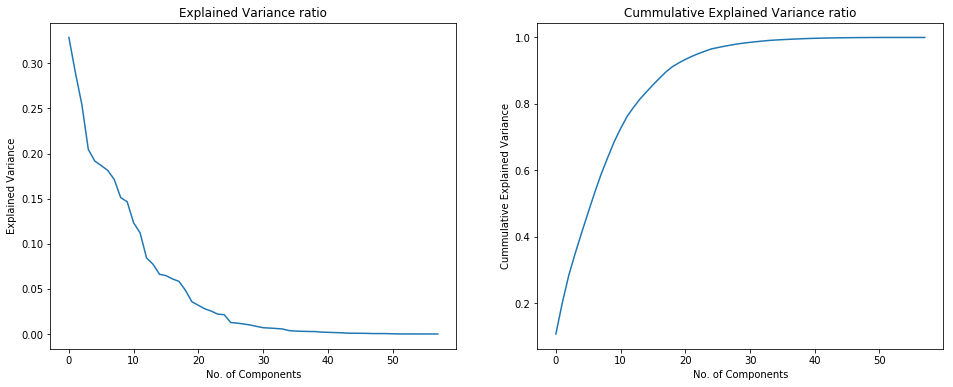

In [82]:
pca = PCA(random_state = 2)
pca.fit(X_train)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Explained Variance plot
ax[0].plot(pca.explained_variance_)
ax[0].set_title('Explained Variance ratio')
ax[0].set(xlabel='No. of Components', ylabel='Explained Variance')

# Cummulative variance explained
ax[1].plot(np.cumsum(pca.explained_variance_ratio_))
ax[1].set_title('Cummulative Explained Variance ratio')
ax[1].set(xlabel='No. of Components', ylabel='Cummulative Explained Variance')

#### As observed, 20 components seem to explain the variance of the dataset

In [85]:
pca = PCA(n_components = 20, random_state = 2)
X_train_pca = pca.fit_transform(X_train, y_train)
X_test_pca = pca.fit_transform(X_test, y_test)

### Independent Component Analysis

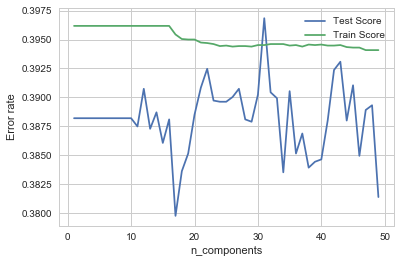

In [86]:
n_components = range(1,50,1)
error_test = []
error_train = []

for i in range(0, len(n_components)):
    ica = FastICA(n_components = n_components[i], whiten = True, random_state=2)
    X_train_ica = ica.fit_transform(X_train, y_train)
    X_test_ica = ica.fit_transform(X_test, y_test)

    # comparing with logistic regression to determine the error rate
    
    logreg = linear_model.LogisticRegression()
    logreg.fit(X_train_ica, y_train)
    
    error_test.append(zero_one_loss(y_test, logreg.predict(X_test_ica)))
    error_train.append(zero_one_loss(y_train, logreg.predict(X_train_ica)))


sns.set(style="whitegrid")


plt.plot(n_components, error_test)
plt.plot(n_components, error_train)
plt.xlabel('n_components')
plt.ylabel('Error rate')

plt.legend(['Test Score', 'Train Score'])

#### 18 components seem to be a good choice for number of indepedent components

In [87]:
ica = FastICA(n_components = 18, whiten = True, random_state = 2)
X_train_ica = ica.fit_transform(X_train, y_train)
X_test_ica = ica.fit_transform(X_test, y_test)

### Randomized Projections

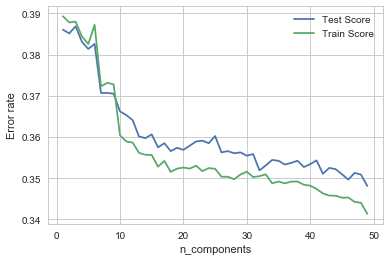

In [88]:
n_components = range(1,50,1)
error_test = []
error_train = []

for i in range(0, len(n_components)):
    ra = random_projection.GaussianRandomProjection(n_components = n_components[i], random_state=7)
    X_train_ra = ra.fit_transform(X_train)
    X_test_ra = ra.fit_transform(X_test, y_test)

    # comparing with logistic regression to determine the error rate
    
    logreg = linear_model.LogisticRegression()
    logreg.fit(X_train_ra, y_train)
    
    error_test.append(zero_one_loss(y_test, logreg.predict(X_test_ra)))
    error_train.append(zero_one_loss(y_train, logreg.predict(X_train_ra)))


sns.set(style="whitegrid")


plt.plot(n_components, error_test)
plt.plot(n_components, error_train)
plt.xlabel('n_components')
plt.ylabel('Error rate')

plt.legend(['Test Score', 'Train Score'])

#### 18 components seem to be a good choice for number of randomized components

In [90]:
ra = random_projection.GaussianRandomProjection(n_components = 18, random_state = 2)
ra.fit(X_train)
X_train_ra = ra.fit_transform(X_train)
X_test_ra = ra.fit_transform(X_test, y_test)

## Task 3

## Clustering post dimensionality reduction

### K means 

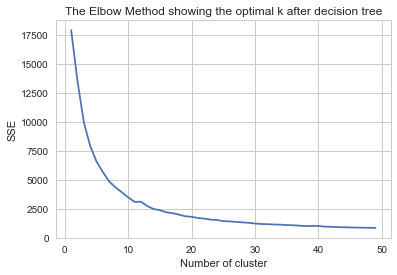

In [94]:
# Post decision tree

sse = {}
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, random_state=2).fit(X_train_dt)
    # kmeans.fit(X_train)
    # data["clusters"] = kmeans.labels_
    # print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title('The Elbow Method showing the optimal k after decision tree')
plt.show()

For n_clusters = 10 The average silhouette_score is : 0.5006198217011537


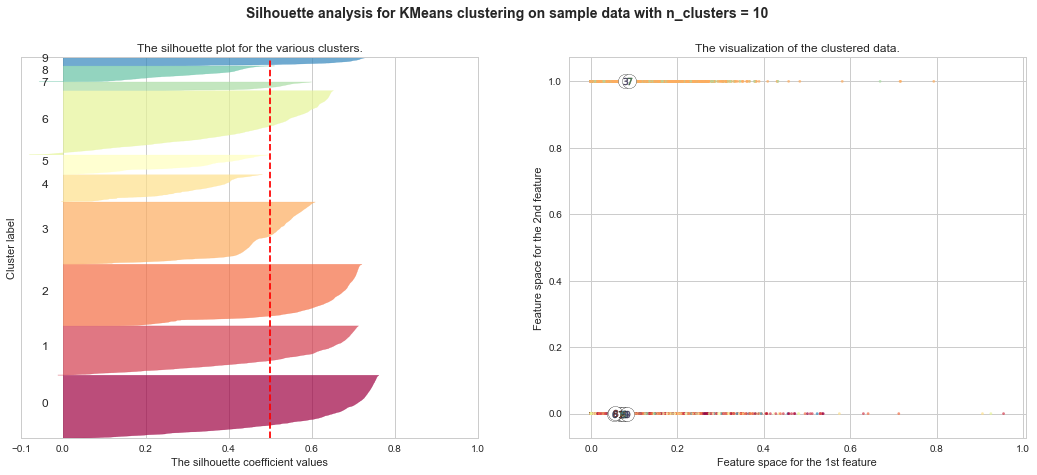

In [146]:
plot_cluster(10, X_train_dt)

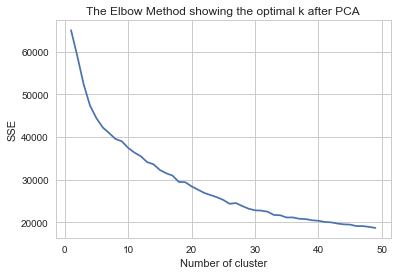

In [95]:
# Post PCA

sse = {}
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, random_state=2).fit(X_train_pca)
    # kmeans.fit(X_train)
    # data["clusters"] = kmeans.labels_
    # print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title('The Elbow Method showing the optimal k after PCA')
plt.show()

For n_clusters = 5 The average silhouette_score is : 0.19160045529852332


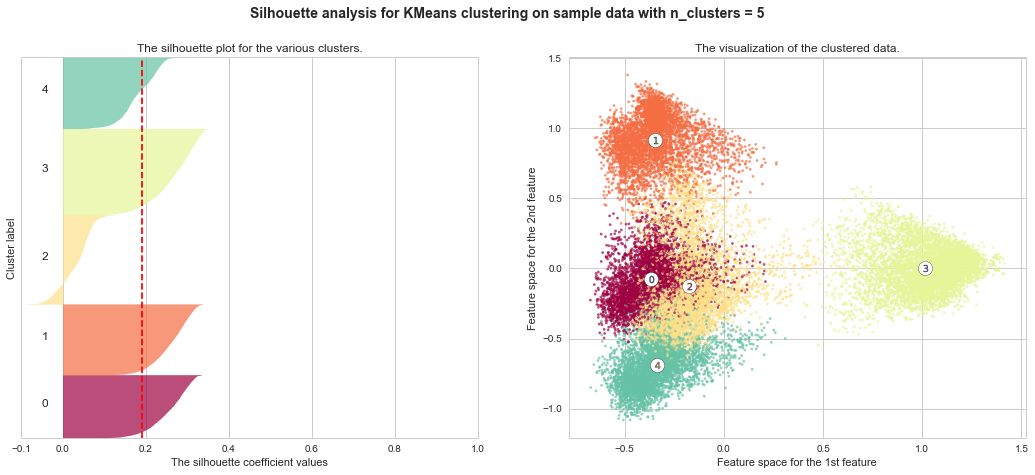

In [147]:
plot_cluster(5, X_train_pca)

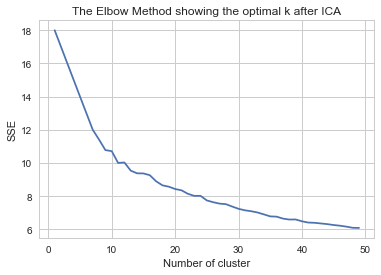

In [96]:
# Post ICA

sse = {}
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, random_state=2).fit(X_train_ica)
    # kmeans.fit(X_train)
    # data["clusters"] = kmeans.labels_
    # print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title('The Elbow Method showing the optimal k after ICA')
plt.show()

For n_clusters = 8 The average silhouette_score is : 0.21208132512541536


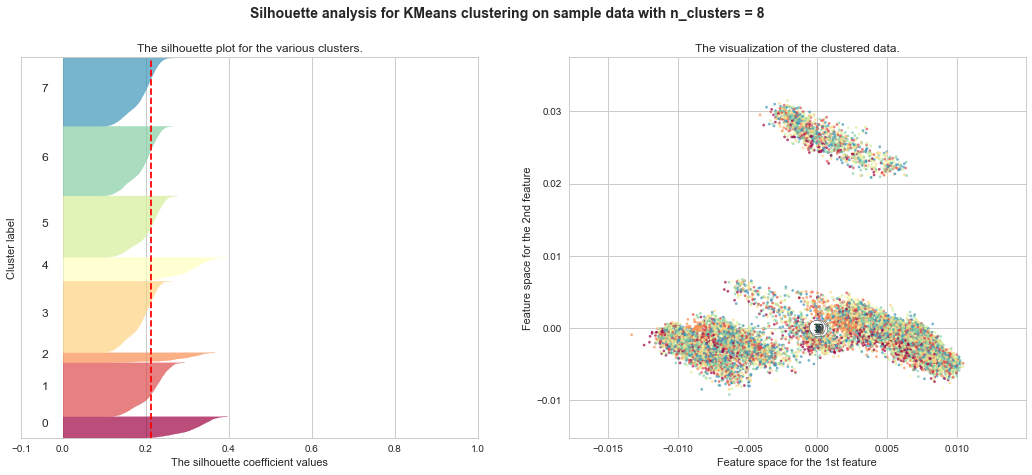

In [150]:
plot_cluster(8, X_train_ica)

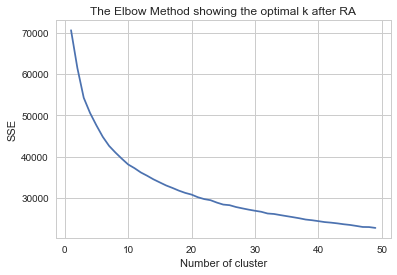

In [97]:
# Post RA

sse = {}
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, random_state=2).fit(X_train_ra)
    # kmeans.fit(X_train)
    # data["clusters"] = kmeans.labels_
    # print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title('The Elbow Method showing the optimal k after RA')
plt.show()

For n_clusters = 8 The average silhouette_score is : 0.13343210507240016


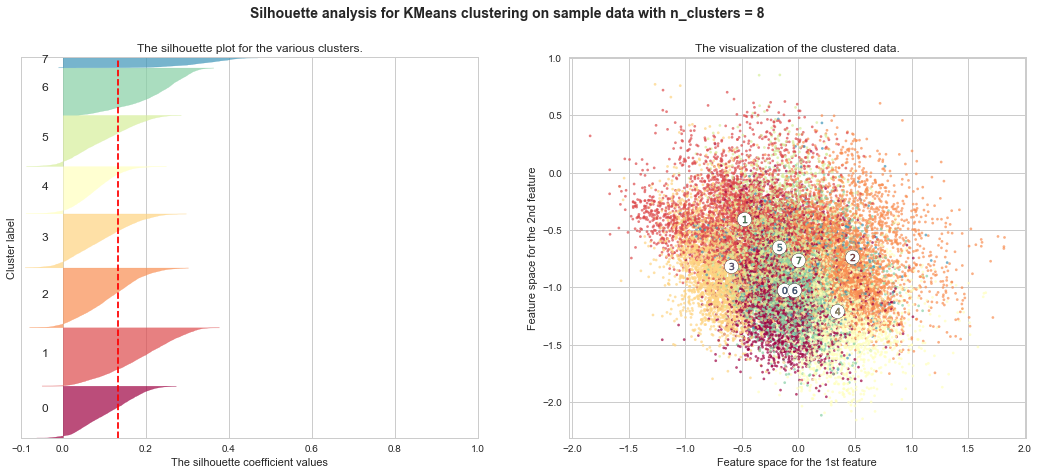

In [155]:
plot_cluster(8, X_train_ra)

### Expectation Maximization

Text(0.5,1,'The AIC/BIC plot for Expectation Maximization after decision tree')

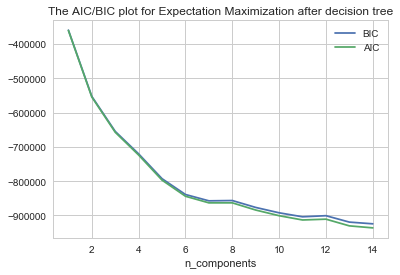

In [100]:
## Post decision tree

n_components = np.arange(1, 15)
models = [GMM(n, covariance_type='full', random_state=2).fit(X_train_dt)
          for n in n_components]

plt.plot(n_components, [m.bic(X_train_dt) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_train_dt) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');
plt.title('The AIC/BIC plot for Expectation Maximization after decision tree')

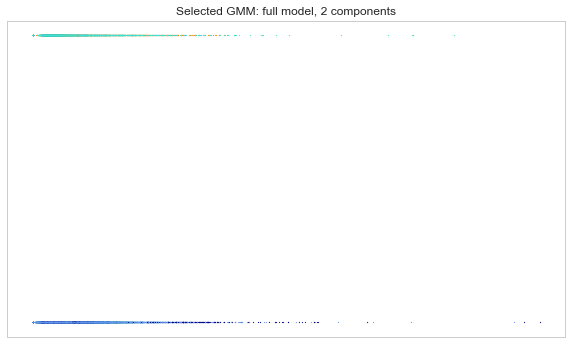

In [166]:
clf = mixture.GaussianMixture(n_components=7, covariance_type='full')
clf.fit(X_train_dt)
plt.figure(figsize = (10,12))
splot = plt.subplot(2, 1, 2)
EM_win(X_train_dt, splot, clf)

Text(0.5,1,'The AIC/BIC plot for Expectation Maximization after PCA')

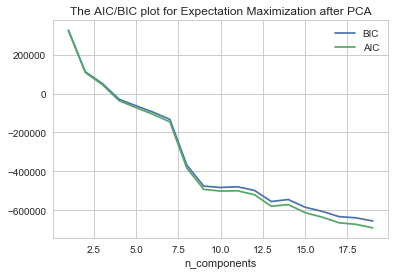

In [101]:
## Post PCA

n_components = np.arange(1, 20)
models = [GMM(n, covariance_type='full', random_state=2).fit(X_train_pca)
          for n in n_components]

plt.plot(n_components, [m.bic(X_train_pca) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_train_pca) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');
plt.title('The AIC/BIC plot for Expectation Maximization after PCA')

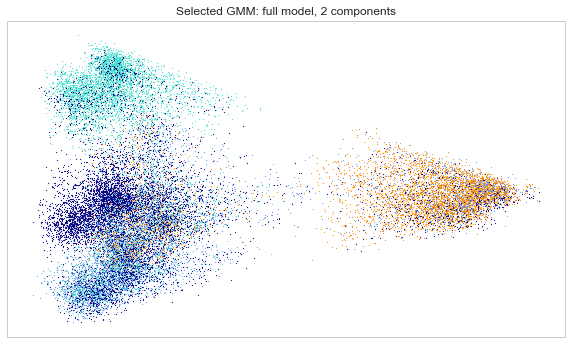

In [163]:
clf = mixture.GaussianMixture(n_components=9, covariance_type='full')
clf.fit(X_train_pca)
plt.figure(figsize = (10,12))
splot = plt.subplot(2, 1, 2)
EM_win(X_train_pca, splot, clf)

Text(0.5,1,'The AIC/BIC plot for Expectation Maximization after ICA')

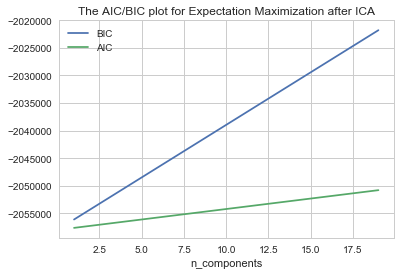

In [104]:
## Post ICA

n_components = np.arange(1, 20)
models = [GMM(n, covariance_type='full', random_state=2).fit(X_train_ica)
          for n in n_components]

plt.plot(n_components, [m.bic(X_train_ica) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_train_ica) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');
plt.title('The AIC/BIC plot for Expectation Maximization after ICA')

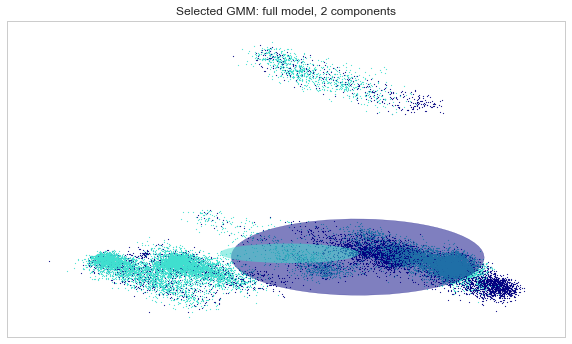

In [164]:
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X_train_ica)
plt.figure(figsize = (10,12))
splot = plt.subplot(2, 1, 2)
EM_win(X_train_ica, splot, clf)

Text(0.5,1,'The AIC/BIC plot for Expectation Maximization after RA')

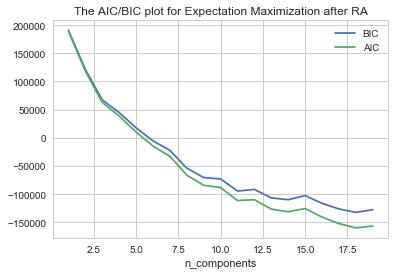

In [103]:
## Post RA

n_components = np.arange(1, 20)
models = [GMM(n, covariance_type='full', random_state=2).fit(X_train_ra)
          for n in n_components]

plt.plot(n_components, [m.bic(X_train_ra) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_train_ra) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');
plt.title('The AIC/BIC plot for Expectation Maximization after RA')

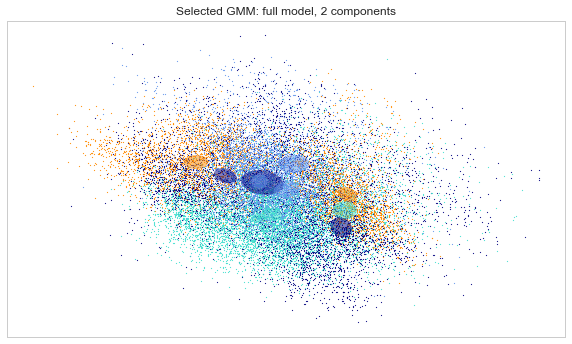

In [165]:
clf = mixture.GaussianMixture(n_components=11, covariance_type='full')
clf.fit(X_train_ra)
plt.figure(figsize = (10,12))
splot = plt.subplot(2, 1, 2)
EM_win(X_train_ra, splot, clf)

## Task 4

## Neural Netwroks post Dimension reduction

#### Post Decision Tree

In [113]:
mlp = MLPClassifier(hidden_layer_sizes=(10,5,2), activation = 'tanh', tol=1e-4, random_state=2)
mlp.fit(X_train_dt, y_train_dt)
#y_pred_nn = mlp.predict(X_test_dt)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=2, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [112]:
print(confusion_matrix(y_test_dt,y_pred_nn))  
print(classification_report(y_test_dt,y_pred_nn))

[[6014    0]
 [3816    0]]
             precision    recall  f1-score   support

          0       0.61      1.00      0.76      6014
          1       0.00      0.00      0.00      3816

avg / total       0.37      0.61      0.46      9830



Confusion matrix, without normalization
[[6014    0]
 [3816    0]]


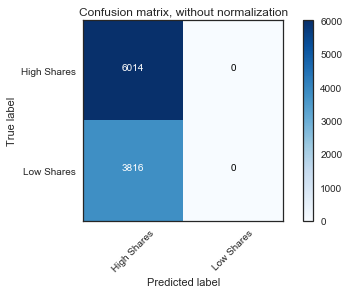

In [114]:
sns.set_style('white')

## Confusion Matrix

class_names = ['High Shares', 'Low Shares']

y_pred = mlp.predict(X_test_dt)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_dt, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

### Post PCA

In [123]:
mlp = MLPClassifier(hidden_layer_sizes=(10,5,2), activation = 'tanh', tol=1e-4, random_state=2)
mlp.fit(X_train_pca, y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=2, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [124]:
y_pred = mlp.predict(X_test_pca)
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))

[[4801 1213]
 [2413 1403]]
             precision    recall  f1-score   support

          0       0.67      0.80      0.73      6014
          1       0.54      0.37      0.44      3816

avg / total       0.62      0.63      0.61      9830



Confusion matrix, without normalization
[[4801 1213]
 [2413 1403]]


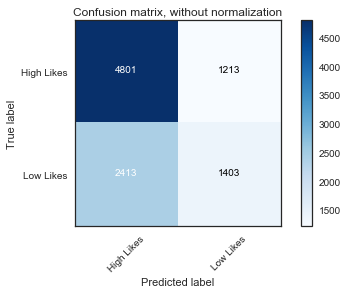

In [125]:
sns.set_style('white')

## Confusion Matrix

class_names = ['High Likes', 'Low Likes']


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

### Post ICA

In [126]:
mlp = MLPClassifier(hidden_layer_sizes=(10,5,2), activation = 'tanh', tol=1e-4, random_state=2)
mlp.fit(X_train_ica, y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=2, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [127]:
y_pred = mlp.predict(X_test_ica)
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))

[[4404 1610]
 [2440 1376]]
             precision    recall  f1-score   support

          0       0.64      0.73      0.69      6014
          1       0.46      0.36      0.40      3816

avg / total       0.57      0.59      0.58      9830



Confusion matrix, without normalization
[[4404 1610]
 [2440 1376]]


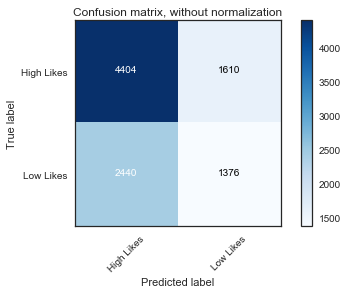

In [128]:
sns.set_style('white')

## Confusion Matrix

class_names = ['High Likes', 'Low Likes']


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

### Post RA

In [129]:
mlp = MLPClassifier(hidden_layer_sizes=(10,5,2), activation = 'tanh', tol=1e-4, random_state=2)
mlp.fit(X_train_ra, y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=2, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [130]:
y_pred = mlp.predict(X_test_ra)
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))

[[4814 1200]
 [2283 1533]]
             precision    recall  f1-score   support

          0       0.68      0.80      0.73      6014
          1       0.56      0.40      0.47      3816

avg / total       0.63      0.65      0.63      9830



Confusion matrix, without normalization
[[4814 1200]
 [2283 1533]]


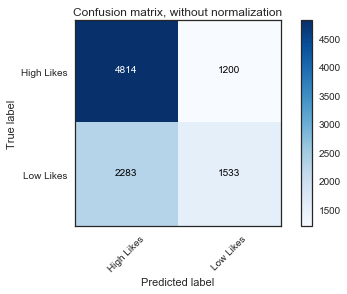

In [131]:
sns.set_style('white')

## Confusion Matrix

class_names = ['High Likes', 'Low Likes']


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

## Task 5

### Neural Networks with post clustering data

#### using k means features

In [132]:
features_kmeans_train = y_pred_kmeans_train.reshape(-1,1)
features_kmeans_test = y_pred_kmeans_test.reshape(-1,1)

In [133]:
mlp = MLPClassifier(hidden_layer_sizes=(10,5,2), activation = 'tanh', tol=1e-4, random_state=2)
mlp.fit(features_kmeans_train, y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=2, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [134]:
y_pred = mlp.predict(features_kmeans_test)
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))

[[5600  414]
 [3204  612]]
             precision    recall  f1-score   support

          0       0.64      0.93      0.76      6014
          1       0.60      0.16      0.25      3816

avg / total       0.62      0.63      0.56      9830



Confusion matrix, without normalization
[[5600  414]
 [3204  612]]


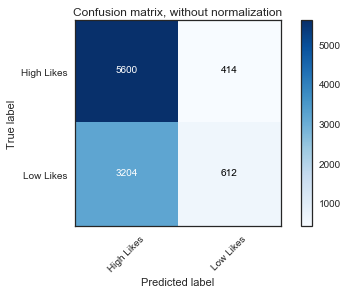

In [135]:
sns.set_style('white')

## Confusion Matrix

class_names = ['High Likes', 'Low Likes']


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

#### using expectation maximization features

In [136]:
features_gmm_train = y_pred_gmm_train.reshape(-1,1)
features_gmm_test = y_pred_gmm_test.reshape(-1,1)

In [137]:
mlp = MLPClassifier(hidden_layer_sizes=(10,5,2), activation = 'tanh', tol=1e-4, random_state=2)
mlp.fit(features_gmm_train, y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=2, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [138]:
y_pred = mlp.predict(features_gmm_test)
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))

[[6014    0]
 [3816    0]]
             precision    recall  f1-score   support

          0       0.61      1.00      0.76      6014
          1       0.00      0.00      0.00      3816

avg / total       0.37      0.61      0.46      9830



Confusion matrix, without normalization
[[6014    0]
 [3816    0]]


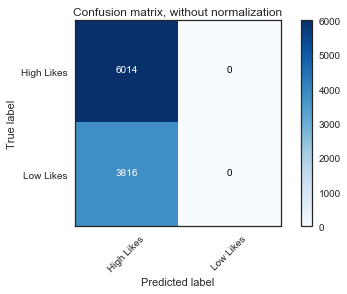

In [139]:
sns.set_style('white')

## Confusion Matrix

class_names = ['High Likes', 'Low Likes']


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

## End of Code